In [346]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.sql.window import Window

## creating spark session and loading data from hdfs

In [ ]:
# create spark session
spark = SparkSession.builder \
        .appName("Market Campaign Analysis") \
        .getOrCreate()

hdfs_path = '/tmp/input_data/'

# movies dataframe
movies_df = spark.read.format('csv').option('header', 'true').option('inferSchema', 'true').load(hdfs_path + 'movies.csv')

# print schema
movies_df.printSchema()

# print data
movies_df.show(truncate=False, n=5)

root
 |-- movieId: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- genres: string (nullable = true)

+-------+----------------------------------+-------------------------------------------+
|movieId|title                             |genres                                     |
+-------+----------------------------------+-------------------------------------------+
|1      |Toy Story (1995)                  |Adventure|Animation|Children|Comedy|Fantasy|
|2      |Jumanji (1995)                    |Adventure|Children|Fantasy                 |
|3      |Grumpier Old Men (1995)           |Comedy|Romance                             |
|4      |Waiting to Exhale (1995)          |Comedy|Drama|Romance                       |
|5      |Father of the Bride Part II (1995)|Comedy                                     |
+-------+----------------------------------+-------------------------------------------+
only showing top 5 rows



In [ ]:
# ratings dataframe
ratings_df = spark.read.csv(path=hdfs_path + 'ratings.csv', header=True, inferSchema=True)

# print schema
ratings_df.printSchema()

# print data
ratings_df.show(truncate=False, n=5)

root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: integer (nullable = true)

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|1     |1      |4.0   |964982703|
|1     |3      |4.0   |964981247|
|1     |6      |4.0   |964982224|
|1     |47     |5.0   |964983815|
|1     |50     |5.0   |964982931|
+------+-------+------+---------+
only showing top 5 rows



In [ ]:
# tags dataframe
tags_df = spark.read.csv(path=hdfs_path + 'tags.csv', header=True, inferSchema=True)

# print schema
tags_df.printSchema()

# print data
tags_df.show(truncate=False,  n=5)

root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- tag: string (nullable = true)
 |-- timestamp: integer (nullable = true)

+------+-------+---------------+----------+
|userId|movieId|tag            |timestamp |
+------+-------+---------------+----------+
|2     |60756  |funny          |1445714994|
|2     |60756  |Highly quotable|1445714996|
|2     |60756  |will ferrell   |1445714992|
|2     |89774  |Boxing story   |1445715207|
|2     |89774  |MMA            |1445715200|
+------+-------+---------------+----------+
only showing top 5 rows



## Analysis

#### Show the aggregated number of ratings per year

In [50]:
yearly_agg_rating = ratings_df.withColumn('timestamp', from_unixtime(col('timestamp'))) \
            .groupby(year(col('timestamp'))) \
            .agg(count('rating').alias('total_ratings'))

In [51]:
yearly_agg_rating.show(n=5)

+---------------+-------------+
|year(timestamp)|total_ratings|
+---------------+-------------+
|           2003|         4014|
|           2007|         7114|
|           2018|         6418|
|           2015|         6616|
|           2006|         4059|
+---------------+-------------+
only showing top 5 rows



In [52]:
# writing output to hdfs
yearly_agg_rating.write.format('csv').option('header', 'true').save('/tmp/output_data/yearly_agg_rating')
print('Write Successfull')

Write Successfull


#### output is written to the hdfs

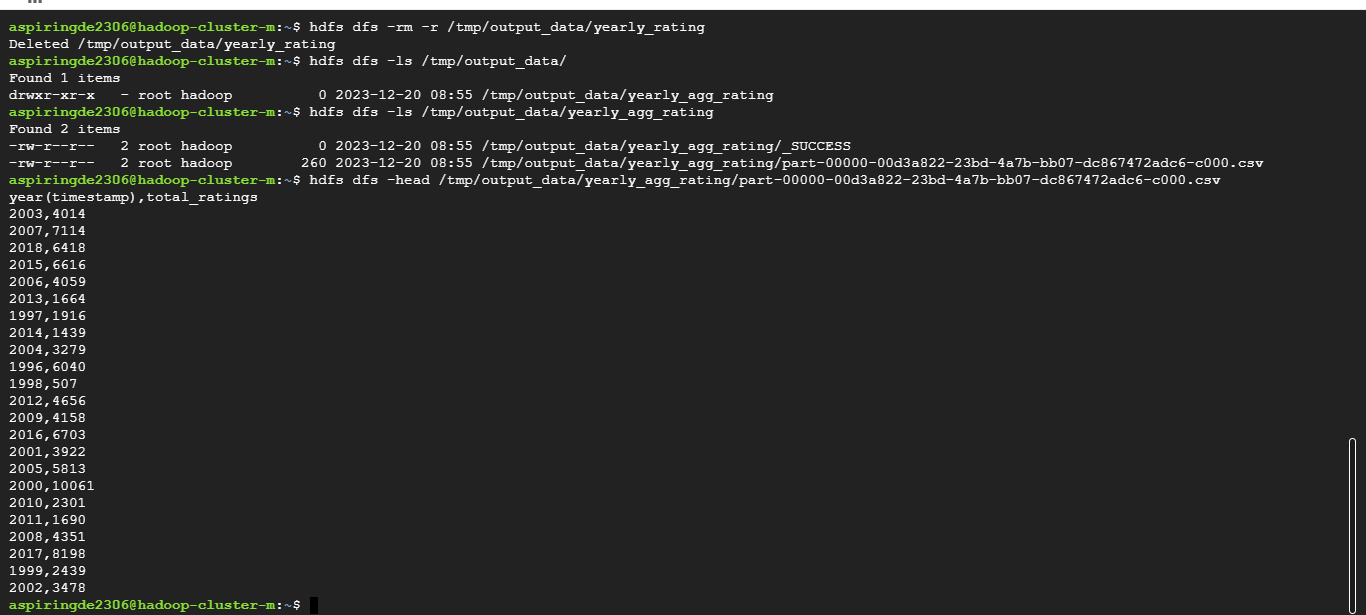

#### Show the rating levels distribution

In [53]:
ratings_df.show(2)

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     1|      1|   4.0|964982703|
|     1|      3|   4.0|964981247|
+------+-------+------+---------+
only showing top 2 rows



In [82]:
rating_distribution = ratings_df.groupby('rating') \
            .agg(round((count('*')*100)/ratings_df.count(), 2).alias('rating_dist'))

In [80]:
rating_distribution.show(n=5)

+------+-----------+
|rating|rating_dist|
+------+-----------+
|   3.5|      13.03|
|   4.5|       8.48|
|   2.5|        5.5|
|   1.0|       2.79|
|   4.0|       26.6|
+------+-----------+
only showing top 5 rows



In [81]:
# writing output to hdfs
rating_distribution.write.format('csv').option('header', 'true').save('/tmp/output_data/rating_distribution')
print('Write Successfull')

Write Successfull


#### output is written to the hdfs

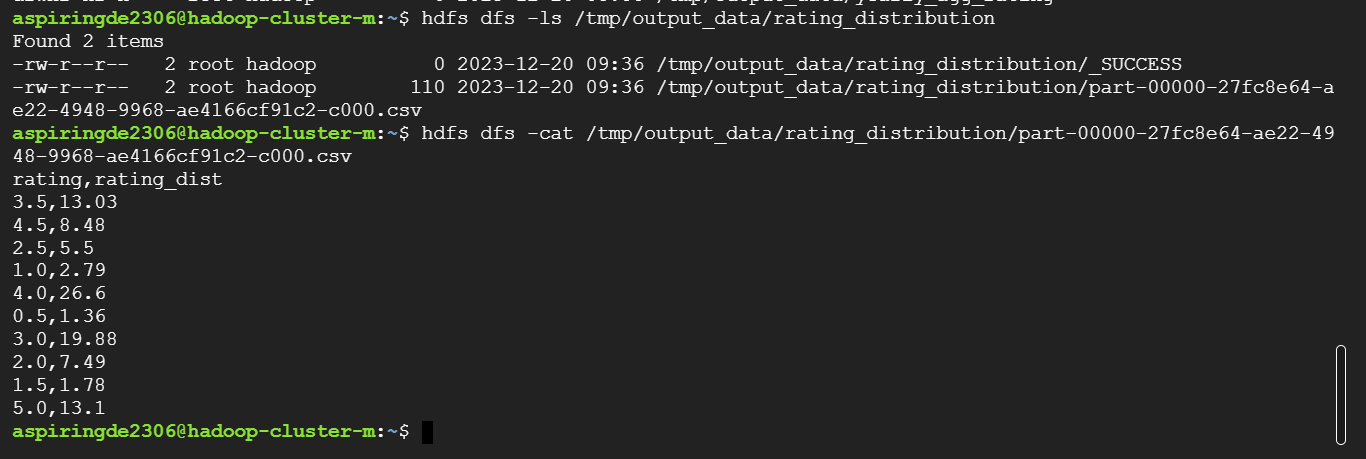

#### Show the 18 movies that are tagged but not rated

In [109]:
unrated_tagged_movies = tags_df.select(col('movieId')).distinct() \
             .exceptAll(ratings_df.select(col('movieId')).distinct()).alias('tmp') \
             .join(movies_df.alias('m'), col('m.movieId') == col('tmp.movieId'), 'inner') \
             .select(col('m.movieId'), col('m.title'))

In [110]:
unrated_tagged_movies.show(truncate=False, n=5)

+-------+--------------------------------------------+
|movieId|title                                       |
+-------+--------------------------------------------+
|3456   |Color of Paradise, The (Rang-e khoda) (1999)|
|7020   |Proof (1991)                                |
|2939   |Niagara (1953)                              |
|6668   |Road Home, The (Wo de fu qin mu qin) (1999) |
|7792   |Parallax View, The (1974)                   |
+-------+--------------------------------------------+
only showing top 5 rows



In [111]:
# writing output to hdfs
unrated_tagged_movies.write.format('csv').option('header', 'true').save('/tmp/output_data/unrated_tagged_movies')
print('Write Successfull')

Write Successfull


#### output is written to hdfs

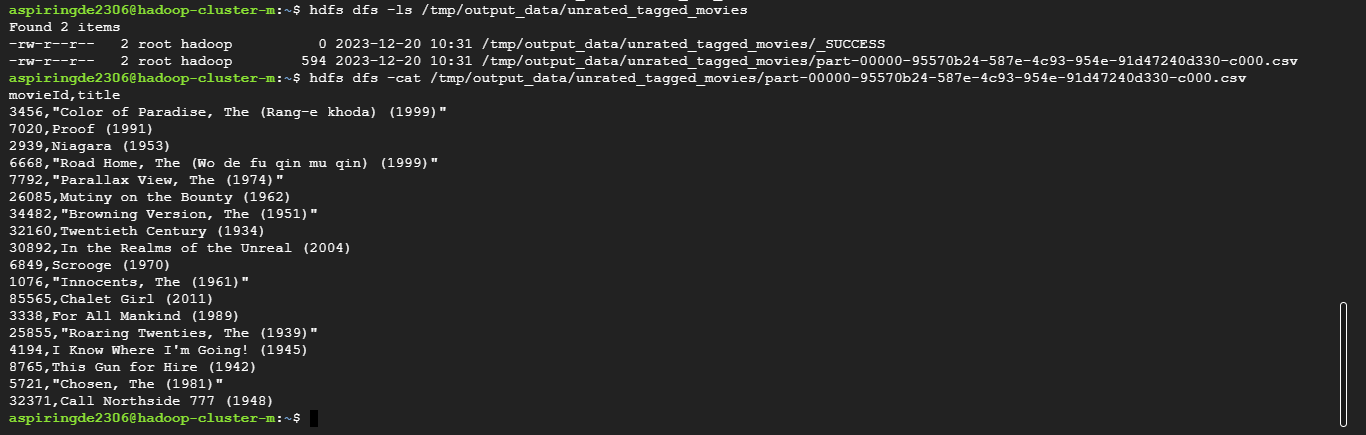

#### Focusing on the rated untagged movies with more than 30 user ratings, show the top 10 movies in terms of average rating and number of ratings

In [194]:
rated_untagged_movies = ratings_df \
        .groupby('movieId') \
        .agg(
             count('*').alias('movie_rating_count'), 
             avg('rating').alias('movie_avg_rating')
         ) \
        .filter(col('movie_rating_count') > 30) \
        .orderBy(
                 col('movie_avg_rating').desc(), 
                 col('movie_rating_count').desc()
         ) \
        .select(col('movieId')) \
        .exceptAll(tags_df.select(col('movieId'))).limit(10)

In [195]:
rated_untagged_movies.show()

+-------+
|movieId|
+-------+
|   2580|
|   1127|
|   3698|
|   1884|
|   1265|
|   2231|
|   4239|
|  33615|
|   8665|
|   6934|
+-------+



In [197]:
# writing output to hdfs
rated_untagged_movies.write.format('csv').option('header', 'true').save('/tmp/output_data/rated_untagged_movies')
print('Write Successfull')

Write Successfull


#### output is written to hdfs

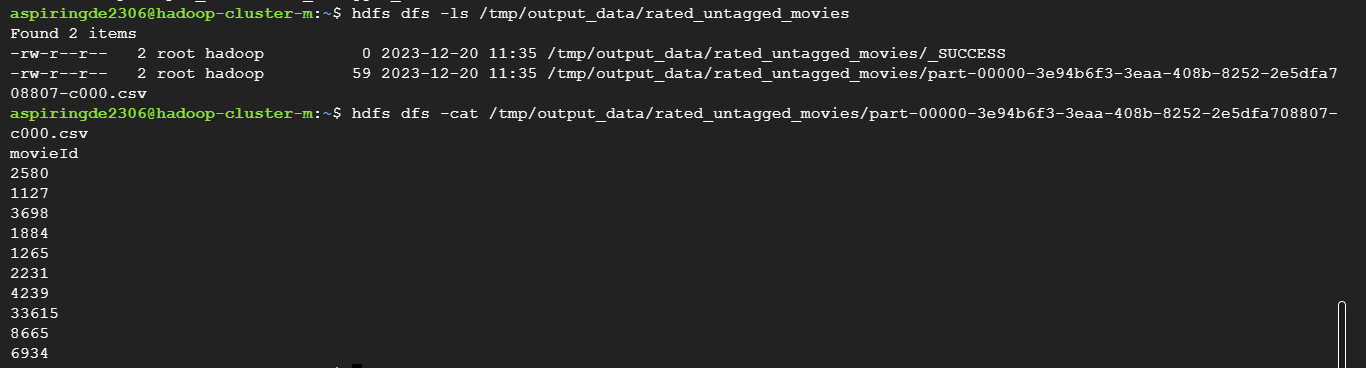

#### What is the average number of tags per movie in tagsDF? And the average number of tags per user? How does it compare with the average number of tags a user assigns to a movie?

In [261]:
average_tags_per_movie = tags_df \
    .groupby('movieId') \
    .agg(count('tag').alias('movie_tag_count')) \
    .select(round(avg(col('movie_tag_count')), 2).alias('avg_tags_per_movie'))

average_tags_per_user = tags_df \
    .groupby('userId') \
    .agg(count('tag').alias('user_tag_count')) \
    .select(round(avg(col('user_tag_count')) ,2).alias('avg_tags_per_user'))

avg_tags_per_movie_by_user = tags_df \
    .groupby('userId', 'movieId') \
    .agg(count('tag').alias('user_tag_count_per_movie')) \
    .groupby('userId') \
    .agg(avg('user_tag_count_per_movie').alias('avg_tags_per_movie_by_user')) 

In [262]:
average_tags_per_movie.show(n=5)

average_tags_per_user.show(n=5)

avg_tags_per_movie_by_user.show(n=5)

+------------------+
|avg_tags_per_movie|
+------------------+
|              2.34|
+------------------+

+-----------------+
|avg_tags_per_user|
+-----------------+
|             63.5|
+-----------------+

+------+--------------------------+
|userId|avg_tags_per_movie_by_user|
+------+--------------------------+
|   513|                       1.5|
|   193|                       4.0|
|   300|                       1.0|
|    76|                       2.0|
|   606|                       1.0|
+------+--------------------------+
only showing top 5 rows



In [275]:
comparison_df = avg_tags_per_movie_by_user.select(col('userId'), col('avg_tags_per_movie_by_user')) \
        .join(average_tags_per_user, how='cross') \
        .select(round(col('avg_tags_per_user') - col('avg_tags_per_movie_by_user'), 2).alias('diff_tags_user_movie'))

In [277]:
comparison_df.show(5)

+--------------------+
|diff_tags_user_movie|
+--------------------+
|                62.0|
|                59.5|
|                62.5|
|                61.5|
|                62.5|
+--------------------+
only showing top 5 rows



In [278]:
# writing output to hdfs
comparison_df.write.format('csv').option('header', 'true').save('/tmp/output_data/comparison_df')
print('Write Successfull')

Write Successfull


#### output is written to the hdfs

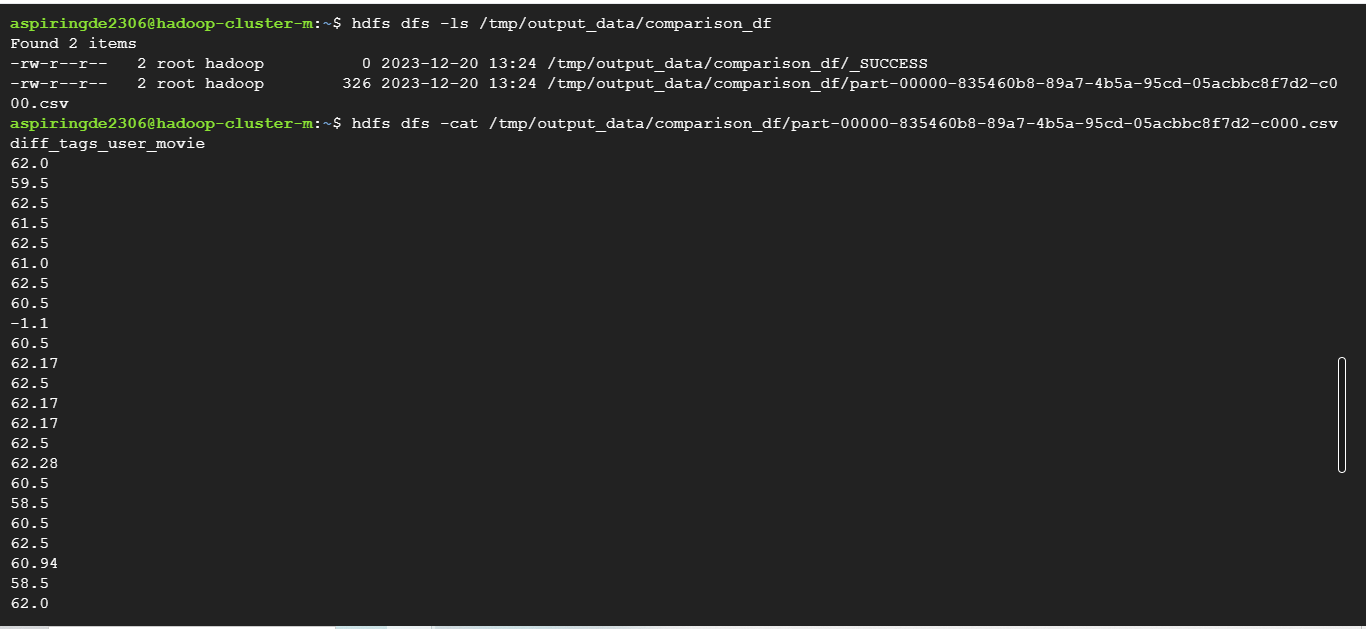

#### Identify the users that tagged movies without rating them

In [295]:
tagged_unrated_by_users = tags_df \
        .select(col('userId'), col('movieId')) \
        .exceptAll(ratings_df.select(col('userId'), col('movieId'))) \
        .select(col('userId')).distinct()

In [298]:
tagged_unrated_by_users.show(n=5)

+------+
|userId|
+------+
|   513|
|   193|
|    76|
|   606|
|   103|
+------+
only showing top 5 rows



In [299]:
# writing output to hdfs
tagged_unrated_by_users.write.format('csv').option('header', 'true').save('/tmp/output_data/tagged_unrated_by_users')
print('Write Successfull')

Write Successfull


#### output is written to the hdfs

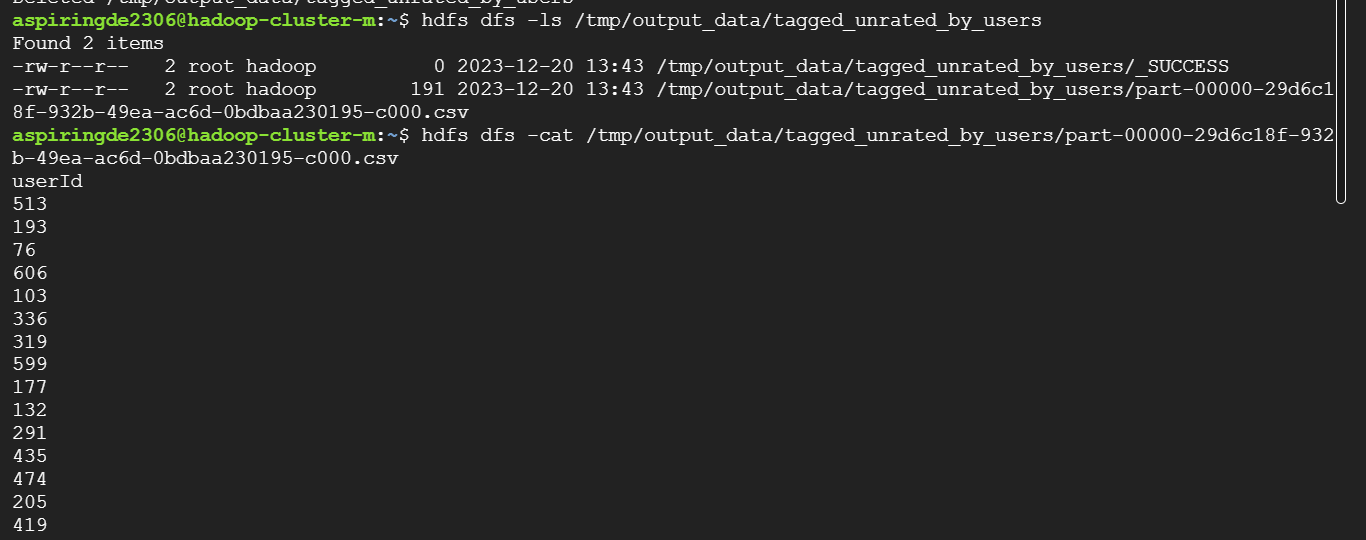

#### What is the predominant (frequency based) genre per rating level?

In [359]:
predominant_genre_per_rating = movies_df \
        .withColumn('genres_array', split(col('genres'), '\|')) \
        .select(col('movieId'), explode(col('genres_array')).alias('genre')).alias('mdf') \
        .join(ratings_df.alias('rdf'), col('mdf.movieId') == col('rdf.movieId'), how='inner') \
        .select(col('rating'), col('genre')) \
        .groupby('rating', 'genre') \
        .agg(count('*').alias('genre_count_per_rating')) \
        .withColumn('predominant_genre', rank().over(Window.partitionBy('rating').orderBy(col('genre_count_per_rating').desc()))) \
        .filter(col('predominant_genre') == 1)

In [360]:
predominant_genre_per_rating.show(n=5)

+------+------+----------------------+-----------------+
|rating| genre|genre_count_per_rating|predominant_genre|
+------+------+----------------------+-----------------+
|   0.5|Comedy|                   632|                1|
|   1.0|Comedy|                  1317|                1|
|   1.5|Comedy|                   895|                1|
|   2.0|Comedy|                  3405|                1|
|   2.5|Comedy|                  2530|                1|
+------+------+----------------------+-----------------+
only showing top 5 rows



In [361]:
# writing output to hdfs
predominant_genre_per_rating.write.format('csv').option('header', 'true').save('/tmp/output_data/predominant_genre_per_rating')
print('Write Successfull')

Write Successfull


#### output is written to the hdfs

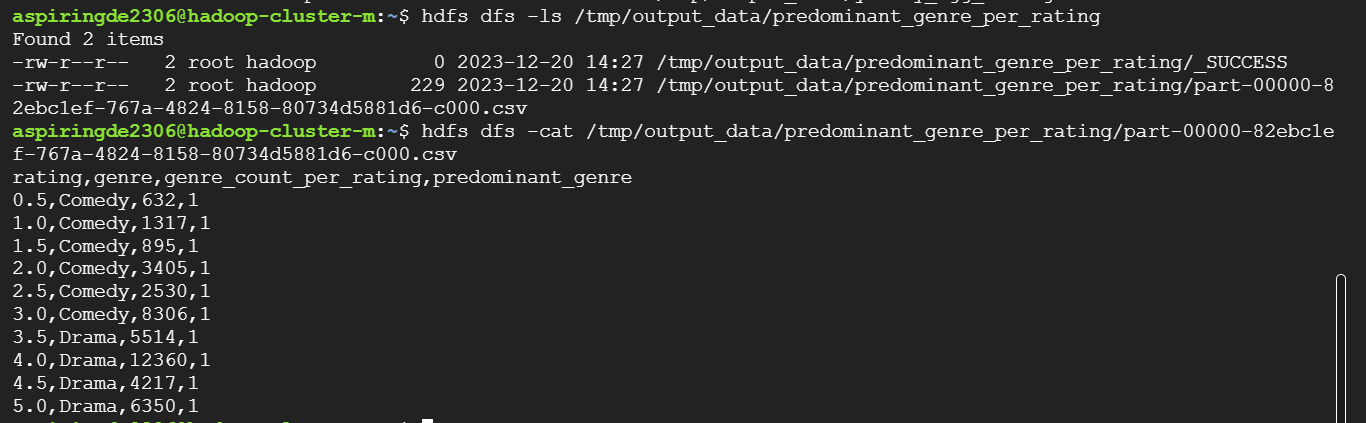

#### What is the predominant tag per genre and the most tagged genres?

In [408]:
most_tagged_genres  = movies_df \
        .withColumn('genres_array', split(col('genres'), '\|')) \
        .select(col('movieId'), explode(col('genres_array')).alias('genre')).alias('mdf') \
        .join(tags_df.alias('tdf'), col('mdf.movieId') == col('tdf.movieId'), how='inner') \
        .groupby('genre', 'tag') \
        .agg(count('tag').alias('tag_count_per_genre')) \
        .withColumn('predominant_tag', rank().over(Window.partitionBy('genre').orderBy(col('tag_count_per_genre').desc()))) \
        .withColumn('tag_sum', sum('tag_count_per_genre').over(Window.partitionBy('genre'))) \
        .filter((col('predominant_tag') == 1) & (col('genre') != '(no genres listed)')) \
        .orderBy(col('tag_sum').desc())

In [409]:
most_tagged_genres.show(n = 5)

+--------+----------------+-------------------+---------------+-------+
|   genre|             tag|tag_count_per_genre|predominant_tag|tag_sum|
+--------+----------------+-------------------+---------------+-------+
|   Drama|In Netflix queue|                 93|              1|   2095|
|  Comedy|In Netflix queue|                 31|              1|   1154|
|Thriller|     atmospheric|                 18|              1|   1099|
|  Action|       superhero|                 23|              1|    837|
|   Crime|In Netflix queue|                 15|              1|    800|
+--------+----------------+-------------------+---------------+-------+
only showing top 5 rows



In [410]:
# writing output to hdfs
most_tagged_genres.write.format('csv').option('header', 'true').save('/tmp/output_data/most_tagged_genres')
print('Write Successfull')

Write Successfull


#### output is written to the hdfs

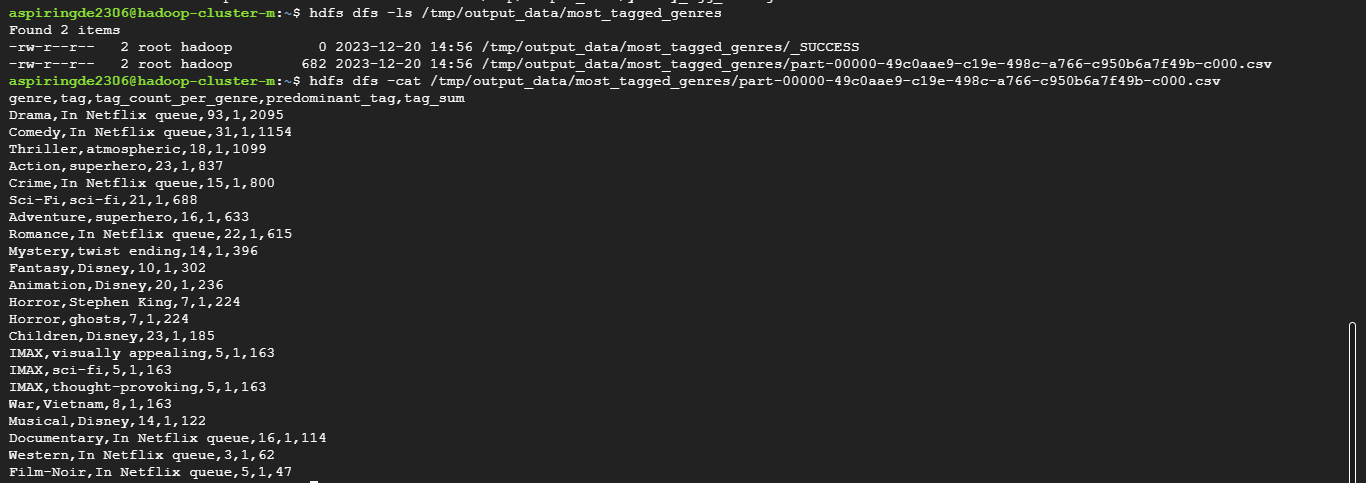

#### What are the most predominant (popularity based) movies?

In [425]:
high_rated_movies = movies_df.alias('mdf') \
        .join(ratings_df.alias('rdf'), col('mdf.movieId') == col('rdf.movieId'), how='inner') \
        .groupby('title') \
        .agg(round(avg('rating'), 3).alias('movie_avg_rating')) \
        .orderBy(col('movie_avg_rating').desc())

In [426]:
high_rated_movies.show(truncate=False)

+-----------------------------------------------------+----------------+
|title                                                |movie_avg_rating|
+-----------------------------------------------------+----------------+
|Radio Day (2008)                                     |5.0             |
|Mother (Madeo) (2009)                                |5.0             |
|Rain (2001)                                          |5.0             |
|Zeitgeist: Moving Forward (2011)                     |5.0             |
|Stuart Little 3: Call of the Wild (2005)             |5.0             |
|Martin Lawrence Live: Runteldat (2002)               |5.0             |
|Tom Segura: Mostly Stories (2016)                    |5.0             |
|Reform School Girls (1986)                           |5.0             |
|Louis Theroux: Law & Disorder (2008)                 |5.0             |
|'Salem's Lot (2004)                                  |5.0             |
|In the blue sea, in the white foam. (1984)        

In [427]:
# writing output to hdfs
high_rated_movies.write.format('csv').option('header', 'true').save('/tmp/output_data/high_rated_movies')
print('Write Successfull')

Write Successfull


#### output is written to the hdfs

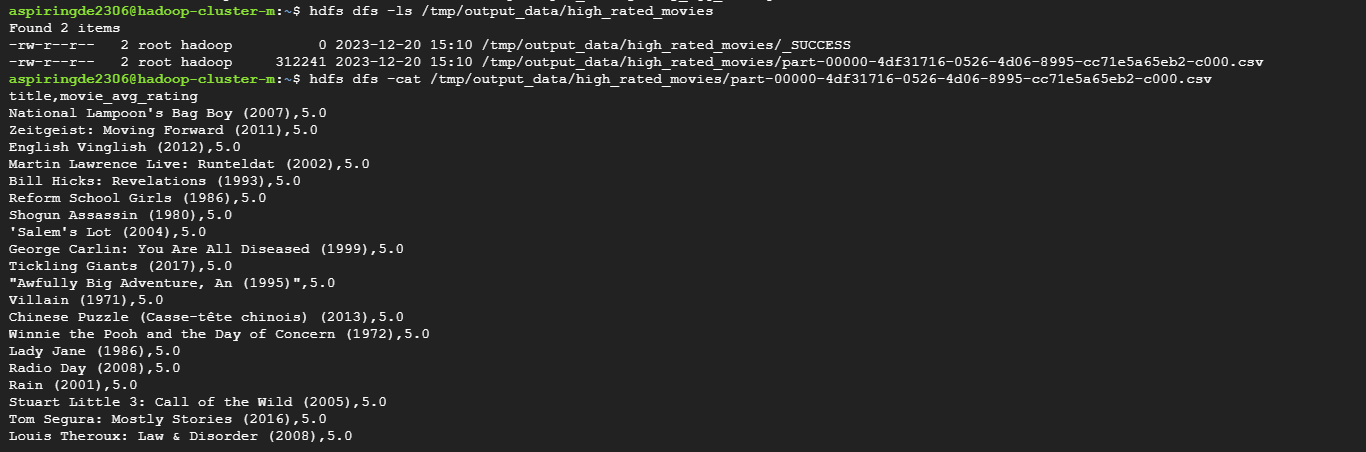

#### Top 10 movies in terms of average rating (provided more than 30 users reviewed them)

In [452]:
top_ten_movies = movies_df.alias('mdf') \
        .join(ratings_df.alias('rdf'), col('mdf.movieId') == col('rdf.movieId'), how='inner') \
        .groupby('title') \
        .agg(
            round(avg('rating'), 3).alias('avg_rating'), 
            count('userId').alias('total_reviews')
        ) \
        .filter(col('total_reviews') > 30) \
        .orderBy(col('avg_rating').desc()).limit(10)

In [453]:
top_ten_movies.show(truncate=False)

+---------------------------------------------------------------------------+----------+-------------+
|title                                                                      |avg_rating|total_reviews|
+---------------------------------------------------------------------------+----------+-------------+
|Shawshank Redemption, The (1994)                                           |4.429     |317          |
|Lawrence of Arabia (1962)                                                  |4.3       |45           |
|Godfather, The (1972)                                                      |4.289     |192          |
|Fight Club (1999)                                                          |4.273     |218          |
|Cool Hand Luke (1967)                                                      |4.272     |57           |
|Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964)|4.268     |97           |
|Rear Window (1954)                                                      

In [450]:
# writing output to hdfs
top_ten_movies.write.format('csv').option('header', 'true').save('/tmp/output_data/top_10_movies')
print('Write Successfull')

Write Successfull


#### output is written to the hdfs

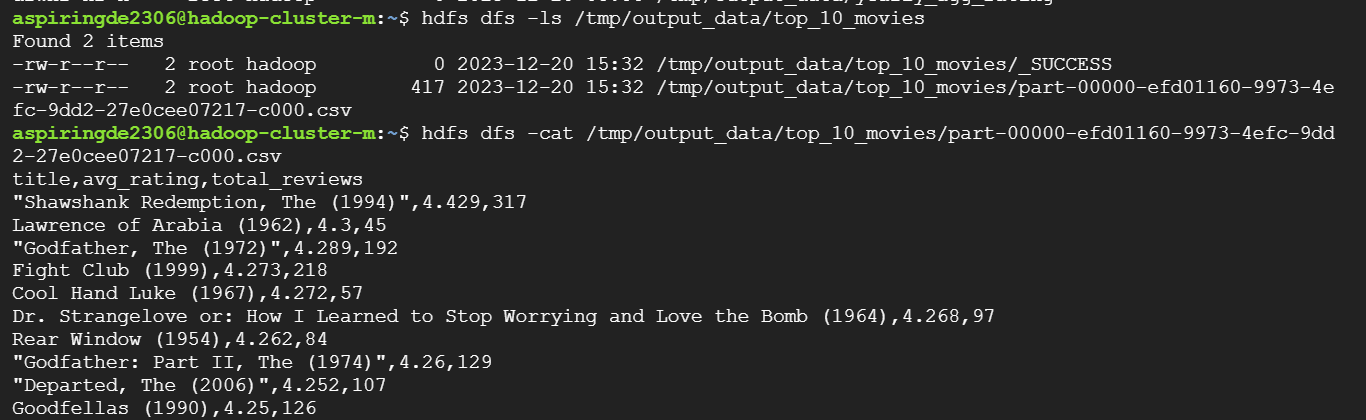